# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [8]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

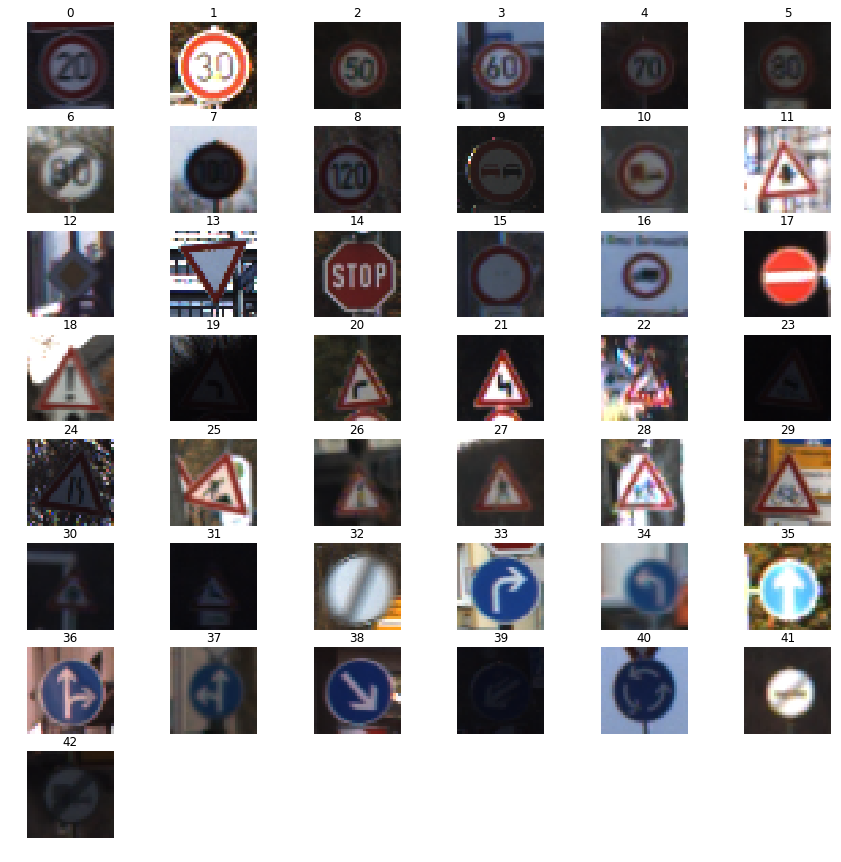

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

def display_images(images, labels):
    i = 1
    plt.figure(figsize=(15,15))
    for label in range(0, len(set(labels))):
        plt.subplot(8, 6, i)
        i += 1
        plt.title(label)
        plt.axis("off")
        plt.imshow(images[np.where(labels == label)[0][1]])
    plt.show()

display_images(X_test, y_test)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [14]:
import cv2
import numpy as np
import random
from skimage import exposure
from collections import Counter
from skimage import transform as tfm

NUMBER_OF_IMAGES_PER_CLASS = 2500
n_classes = len(set(y_train))

            ## ------------- Image modification functions -----------
    
def equalize_hist(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
def brighten(image):
    b, g, r = cv2.split(image)
    red = exposure.equalize_hist(r)
    green = exposure.equalize_hist(g)
    blue = exposure.equalize_hist(b)
    return cv2.merge((blue, green, red))

def translate(image, x=None, y=None):
    rows,cols = image.shape[:2]
    if x is None:
        x = get_random_int(-5,5)
    if y is None:
        y = get_random_int(-5,5)
    
    M = np.float32([[1,0,x],[0,1,y]])
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

def rotate(image, angle=None):
    if angle is None:
        angle = get_random_float(-15, 15)
    rows,cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(image,M,(cols,rows))

def resize(images):
    return [tfm.resize(image, (32, 32))
                for image in images]

def get_brightened_x(x_data=X_train):
    bright_X = np.zeros(x_data.shape)
    for index in range(0, len(x_data)):
        bright_X[index] = brighten(x_data[index])
    print("Done brightening")
    return bright_X
  
def process_image(image):
    i = random.randint(0,1)
    if i == 0:
        return rotate(image)
    else:
        return translate(image)
    
            ##--------- Helper functions -------

def get_indices(data, value):
    return np.where(data == value)

def get_images_of_label(label, x_data=X_train, y_data=y_train):
    if(label < 0):
        raise Exception('Cannot have negative label')
        
    if(label > len(set(y_data))-1):
        raise Exception('Label exceeded data length')

    return np.array(list(x_data[get_indices(y_data, label)]))

def get_random_float(_min, _max):
    return float("{0:.2f}".format(random.uniform(_min, _max)))

def get_random_int(_min, _max):
    return random.randint(_min, _max)


In [15]:
def augment_data(images):
    s = images.shape
    assert len(s) == 4, s
    
    nb_images = NUMBER_OF_IMAGES_PER_CLASS
    in_height = s[1]
    in_width = s[2]
    in_channels = s[3]
    output_data = np.zeros((nb_images,in_height, in_width, in_channels), dtype=np.uint8)
    for img_idx in range(nb_images):
        if(img_idx < s[0]):
            output_data[img_idx] = images[img_idx]
        else:
            mod_idx = img_idx % s[0]
            result_img = process_image(images[mod_idx])
            output_data[img_idx] = result_img
    return output_data
      
def get_final_x():
    final_x = np.zeros([0,32,32,3], dtype=np.uint8)
    for i in range(n_classes):
        final_x = np.concatenate((final_x, augment_data(get_images_of_label(i))))
    print("Done augmenting X")
    return final_x

def get_final_y():
    final_y = []
    for label in range(n_classes):
        verts = [label for x in range(NUMBER_OF_IMAGES_PER_CLASS)]
        final_y.extend(verts)
    print("Done augmenting Y")
    return np.asarray(final_y)

In [5]:
from collections import Counter
Counter(y_train)

Counter({0: 210,
         1: 2220,
         2: 2250,
         3: 1410,
         4: 1980,
         5: 1860,
         6: 420,
         7: 1440,
         8: 1410,
         9: 1470,
         10: 2010,
         11: 1320,
         12: 2100,
         13: 2160,
         14: 780,
         15: 630,
         16: 420,
         17: 1110,
         18: 1200,
         19: 210,
         20: 360,
         21: 330,
         22: 390,
         23: 510,
         24: 270,
         25: 1500,
         26: 600,
         27: 240,
         28: 540,
         29: 270,
         30: 450,
         31: 780,
         32: 240,
         33: 689,
         34: 420,
         35: 1200,
         36: 390,
         37: 210,
         38: 2070,
         39: 300,
         40: 360,
         41: 240,
         42: 240})

In [6]:
final_x_train = get_final_x()
final_y_train = get_final_y()

Done augmenting X
Done augmenting Y


In [7]:
Counter(final_y_train)

Counter({0: 2500,
         1: 2500,
         2: 2500,
         3: 2500,
         4: 2500,
         5: 2500,
         6: 2500,
         7: 2500,
         8: 2500,
         9: 2500,
         10: 2500,
         11: 2500,
         12: 2500,
         13: 2500,
         14: 2500,
         15: 2500,
         16: 2500,
         17: 2500,
         18: 2500,
         19: 2500,
         20: 2500,
         21: 2500,
         22: 2500,
         23: 2500,
         24: 2500,
         25: 2500,
         26: 2500,
         27: 2500,
         28: 2500,
         29: 2500,
         30: 2500,
         31: 2500,
         32: 2500,
         33: 2500,
         34: 2500,
         35: 2500,
         36: 2500,
         37: 2500,
         38: 2500,
         39: 2500,
         40: 2500,
         41: 2500,
         42: 2500})

In [8]:
final_bright_x_train = get_brightened_x(final_x_train)

Done brightening


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

final_bright_x_train, final_y_train = shuffle(final_bright_x_train, final_y_train)

X_train, X_validation, y_train, y_validation = train_test_split(final_bright_x_train, final_y_train, test_size=0.2, random_state=0)

In [10]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_validation.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 86000
Number of testing examples = 21500
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I loaded the data from pickle file and saw few images using plt.imshow. Few images of same label were bright and few were not. So, I brightened up all the images using opencv functions. I tried evening out histograms as well but had better results by brightening instead of histogram evening out. 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** The number of images for each label were significantly different. So I created more data using data augmentation techniques such as rotation and translation. A random angle between -15 and 15 is chosen and the image is rotated. Similarly, a random translation x and y from -5 to 5 are chosen and the image is translated. At the end of it, 2500 images for each label are generated in training set. 

These training images are split into training and validation in 80-20 ratio. 

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The architecture of my model is similar to LeNet architecture but with increase in the depth of fully connected layers.

My model is as follows:

-> Input: 32x32x3

-> 2D conv with 6 filters (Dimensions after this: 28x28x6)

-> Dropout with keep_prob of 0.8

-> Relu activation

-> Max pooling with stride of 2 in w, h dimensions (Dimensions after this: 14x14x6)

-> 2D conv with 16 filters (Dimensions here: 10x10x16)

-> Droput with keep_prob of 0.8

-> Relu activation

-> Max pooling with stide of 2 in w, h dimensions (Dimensions after this: 5x5x16)

-> Flatten (Dimensions after this: 400x1)

-> Fully connected layer 400 inputs to 250 outputs (Dimensions after this: 250x1)

-> Droput with keep_prob of 0.7

-> Fully connected layer 250 inputs to 160 outputs (Dimensions after this: 160x1)

-> Dropout with keep_prob of 0.7

-> Fully connected layer 160 inputs to 84 outputs (Dimensions after this: 84x1)

-> Dropout with keep_prob of 0.7

-> Fully connected layer 84 inputs to 43 outputs (Dimensions after this: 43x1) <- output layer



In [1]:
### Train your model here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 80
BATCH_SIZE = 128
save_path = "./lenet"

In [2]:
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return x

def relu(x):
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def dropout(x, keep_prob=0.5):
    return tf.nn.dropout(x, keep_prob)

def fully_connected(logits, w, b):
    return tf.add(tf.matmul(logits, w), b)

def add_l2_loss(w, beta=0.001):
    return beta*tf.nn.l2_loss(w)

def add_l2_loss_weights(weights):
    for w in weights:
        loss += add_l2_loss(w)
    return loss

def LeNet(x, weights, biases):
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])

    # TODO: Dropout
    conv1 = dropout(conv1, 0.8)
    
    # TODO: Activation.
    conv1 = relu(conv1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])

    # TODO: Dropout
    conv2 = dropout(conv2, 0.8)

    # TODO: Activation.
    conv2 = relu(conv2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
        
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flat_input = flatten(conv2)
    
    # TODO: Fully Connected. 
    logits_d1 = fully_connected(flat_input, weights['wd1'], biases['bd1'])
    
    # TODO: Droput
    logits_d1 = dropout(logits_d1, 0.7)
    
    # TODO: Activation.
    logits_d1 = relu(logits_d1)
    
    # TODO: Layer 4: Fully Connected. Input = 160. Output = 84.
    logits_d2 = fully_connected(logits_d1, weights['wd2'], biases['bd2'])
    
    # TODO: Dropout
    logits_d2 = dropout(logits_d2, 0.7)
    
    # TODO: Activation.
    logits_d2 = relu(logits_d2)
    
    # TODO: Layer 5: Fully Connected. Input = 100, Output = 84
    logits_d3 = fully_connected(logits_d2, weights['wd3'], biases['bd3'])
    
    # TODO: Dropout
    logits_d3 = dropout(logits_d3, 0.7)
    
    # TODO: Activation: 
    logits_d3 = relu(logits_d3)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = fully_connected(logits_d3, weights['out'], biases['out'])
    
    return logits

In [3]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [4]:
rate = 0.001
mu = 0
sigma = 0.2
beta = 0.002

weights = {
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma)),
    'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
    'wd1': tf.Variable(tf.truncated_normal([400, 250], mean=mu, stddev=sigma)),
    'wd2': tf.Variable(tf.truncated_normal([250, 160], mean=mu, stddev=sigma)),
    'wd3': tf.Variable(tf.truncated_normal([160, 100], mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.truncated_normal([100, 43], mean=mu, stddev=sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros([6])),
    'bc2': tf.Variable(tf.zeros([16])),
    'bd1': tf.Variable(tf.zeros([250])),
    'bd2': tf.Variable(tf.zeros([160])),
    'bd3': tf.Variable(tf.zeros([100])),
    'out': tf.Variable(tf.zeros([43]))}
    
logits = LeNet(x, weights, biases)
prediction = tf.nn.softmax(logits)
cross_entropy = -tf.reduce_sum(one_hot_y * tf.log(prediction + 1e-6), reduction_indices=1)
# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)

loss_operation = tf.reduce_mean(cross_entropy) + add_l2_loss(weights['wd1'], beta) + add_l2_loss(weights['wc1']) + add_l2_loss(weights['out'])
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [5]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, save_path)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.284

EPOCH 2 ...
Validation Accuracy = 0.504

EPOCH 3 ...
Validation Accuracy = 0.627

EPOCH 4 ...
Validation Accuracy = 0.693

EPOCH 5 ...
Validation Accuracy = 0.747

EPOCH 6 ...
Validation Accuracy = 0.773

EPOCH 7 ...
Validation Accuracy = 0.800

EPOCH 8 ...
Validation Accuracy = 0.811

EPOCH 9 ...
Validation Accuracy = 0.831

EPOCH 10 ...
Validation Accuracy = 0.837

EPOCH 11 ...
Validation Accuracy = 0.854

EPOCH 12 ...
Validation Accuracy = 0.859

EPOCH 13 ...
Validation Accuracy = 0.868

EPOCH 14 ...
Validation Accuracy = 0.875

EPOCH 15 ...
Validation Accuracy = 0.876

EPOCH 16 ...
Validation Accuracy = 0.881

EPOCH 17 ...
Validation Accuracy = 0.882

EPOCH 18 ...
Validation Accuracy = 0.893

EPOCH 19 ...
Validation Accuracy = 0.893

EPOCH 20 ...
Validation Accuracy = 0.895

EPOCH 21 ...
Validation Accuracy = 0.893

EPOCH 22 ...
Validation Accuracy = 0.899

EPOCH 23 ...
Validation Accuracy = 0.898

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

Optimizer: Adam's optimizer

Batch size: 128

Epochs: 80

Hyperparameters: learning rate of 0.001, l2 regularazation loss of 0.002, dropout with 0.8 prob in conv layer and 0.7 in fully connected layer

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started with LeNet architecture and data from pickel file. I ran the model with changing the classes to 43 from 10 and I got a validation accuracy of 97-98% with 25 epochs and a batch size of 32. However when I used the test set on this model, the results were not satisfactory. To get through with this, I introduced droput and l2 regularization. However, this reduced the validation accuracy of my model for the same number of epochs.

I also noticed that there was a very high variance in the number of images per label. So I used data augmentation techniques like rotation and translation to generate more images. A random angle between -15 and 15 was chosen to rotate an image and a random translation value of -5 to 5 in both x and y direction was chosen to translate the images. At the end of this data augmentation, all the labels had 2500 images each. 

After preprocessing and data augmentation, when I put these images through the LeNet model that I got above, the results were poor. So I increased the number of epochs steadily along with batch size so as to get higher validation accuracies. After doing this for a while, my accuracies did not improve anymore. So I increased the number of fully connected layers and also modified the number of neurons per layer so that I get more 'brain power'. This seemed to have helped in acheiving higher accuracy on validation set. 

My model seemed to work well with validation set (around 97%) but running it on test set was resulting in around 82% of accuracy. So it looked like the model was still overfitting my data. So I tuned my l2 regularization and droput values using trial and error and after few iterations, my validation accuracy came around 95% and my test set was around 93%. 

I would have preferred to acheive more accuracy but did not understand what other parameters I could have changed to make it better. My mentor helped me out by giving me tips along the way on what to do and that helped me a lot.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    bright_X_test = get_brightened_x(X_test)
    test_accuracy = evaluate(bright_X_test, y_test)
    len_x_test=len(X_test)
    prediction=test_accuracy * len_x_test
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Done brightening
Test Accuracy = 0.916


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** I used the training set that was used in https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.wc7d6kjhq for testing my model. 

Out of all those images that were present in the test set, I chose 9 images that were present in the dataset that I first had. However, the images in this dataset are of different dimensions than what I originally had. So I resized them to lower resolution images (32x32x3) so as to make my model understand them. 

My validation set was rotated, translated and brightened dataset of my training set in which the images were of very low resolution and at various angles. The images that I chose for testing my model, were of higher quality than what I trained on and seemed better contrast than what I trained for, the output for my test were better than my validation accuracy. This is why my model seemed to work better on test set more than my validation set which was at around 92%

In [6]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import os
import skimage
from skimage import data

def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

test_data_dir = "./testing/Testing"
images, labels = load_data(test_data_dir)


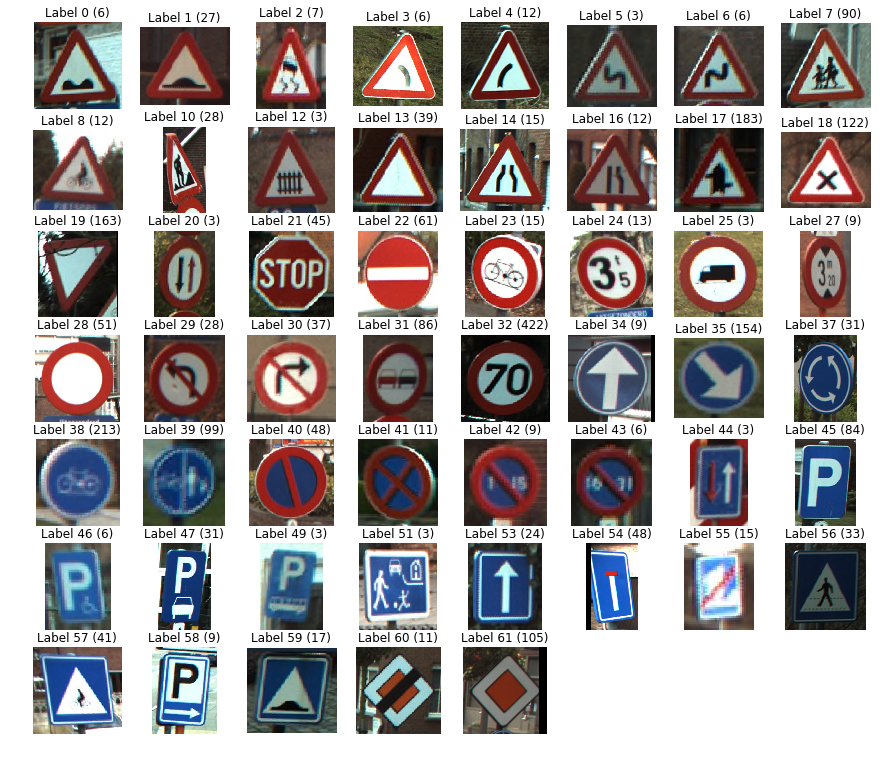

In [10]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

In [11]:
indices_of_interest = []
labels_of_interest = [4, 16, 21, 22, 35, 34, 37, 28]
for label in labels_of_interest:
    all_indices=[]
    all_indices = [i for i, x in enumerate(labels) if x == label]
    indices_of_interest.append(all_indices[0])

In [12]:
# Take 10 images randomly
random_images = [images[y] for y in indices_of_interest]
random_labels = [labels[y] for y in indices_of_interest]
print(random_labels)

[4, 16, 21, 22, 35, 34, 37, 28]


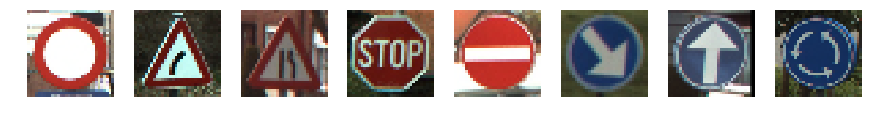

In [16]:
# plt.imshow(random_images[8])
def display_images_and_labels1(images, labels):
    """Display the first image of each label."""
    unique_labels = len(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for count in range(len(labels)):
        # Pick the first image for each label.
        image = images[count-1]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        i += 1
        _ = plt.imshow(image)
    plt.show()

# Resize them to 32x32
test_images_resized = resize(random_images)
test_labels=[15, 20, 24, 14, 17, 38, 35, 40]

display_images_and_labels1(test_images_resized, test_labels)


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The model was able to do it very well mostly because I am using the similar belgian traffic dataset as my training set. I got 8 out of 8 mapped correctly.

In [17]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import csv
def read_data():
    names = {}
    with open('signnames.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader :
            names[int(row['ClassId'])] = row['SignName']
    return names

signnames = read_data()

softmax = tf.nn.softmax(logits)
top_5_var = tf.nn.top_k(softmax,5)

with tf.Session() as sess:
    saver.restore(sess, save_path)
    top_5 = sess.run(top_5_var, feed_dict={x: np.array(test_images_resized), y: np.array(test_labels)})
    print(top_5)

TopKV2(values=array([[  1.00000000e+00,   3.87822254e-08,   3.80501035e-08,
          3.71224758e-08,   1.19012533e-08],
       [  9.97267246e-01,   1.15418108e-03,   5.39263303e-04,
          4.32929373e-04,   2.33854225e-04],
       [  1.00000000e+00,   1.13850296e-09,   5.07331954e-10,
          3.37393058e-10,   3.01101838e-10],
       [  1.00000000e+00,   7.52129817e-14,   2.05303118e-17,
          6.19160860e-18,   1.15331570e-19],
       [  9.96430695e-01,   2.48360215e-03,   4.90362581e-04,
          1.81605705e-04,   1.37988085e-04],
       [  9.99909759e-01,   8.25243769e-05,   7.36704760e-06,
          3.75755434e-07,   4.84937535e-10],
       [  9.99999881e-01,   4.72949893e-08,   2.42261891e-08,
          1.43345007e-08,   5.23960075e-09],
       [  9.99991417e-01,   8.58842304e-06,   4.44788789e-10,
          3.40579648e-10,   1.21076777e-11]], dtype=float32), indices=array([[20, 11, 25, 18, 27],
       [24, 29, 23, 19, 30],
       [14, 18, 15, 12,  4],
       [17, 16, 14

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

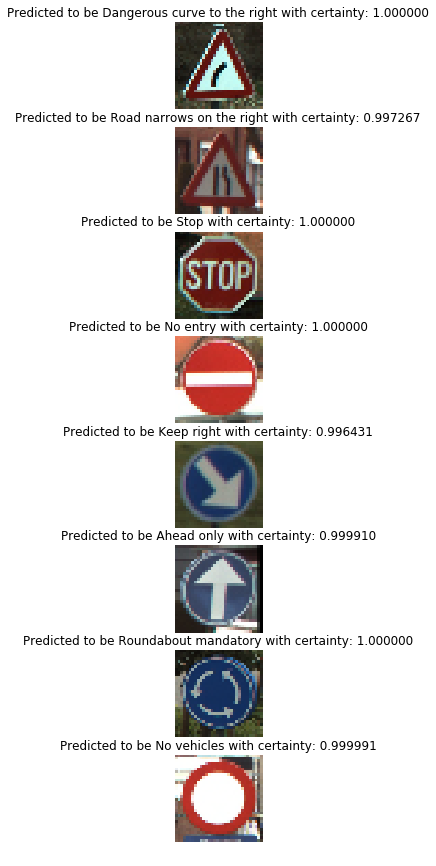

In [18]:
plt.figure(figsize=(17,17))
for i in range(len(test_labels)):
    result = plt.subplot(9,1,i+1)
    plt.imshow(test_images_resized[i])
    plt.axis("off")
    result.set_title("Predicted to be %s with certainty: %f" % (signnames[top_5[1][i][0]], top_5[0][i][0]))

**Answer:** The test images looked to be of a very high resolution and have very good contrast. This can be seend in the top_k results above. 

Each image above has a prediction along with the probability with which the model predicted the model to be. Since most of the test image data set were of higher quality than that of the validation and training set, the accuracy with which the model predicted seemed be very high. 

The model predicted all the 8 images correctly with more than 99% accuracy. 

The Top_KV2 values indicate that the model has a very high confidence in the images and the accuracy is very high in its predictions. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.